使用現有的道瓊2010至2019年1分k資料

In [4]:
#原始檔案前10筆資料
f=open('YM2010-2019.txt','r',encoding='UTF-8')
DD=f.readlines()
DD[:10] 

f.close()

['2010/1/3,17:01:00,8334,8352,8334,8348,80\n',
 '2010/1/3,17:02:00,8348,8349,8346,8349,15\n',
 '2010/1/3,17:03:00,8347,8349,8346,8347,14\n',
 '2010/1/3,17:04:00,8349,8349,8347,8347,3\n',
 '2010/1/3,17:05:00,8346,8350,8345,8350,9\n',
 '2010/1/3,17:06:00,8349,8349,8349,8349,1\n',
 '2010/1/3,17:07:00,8350,8353,8350,8352,23\n',
 '2010/1/3,17:08:00,8349,8349,8349,8349,1\n',
 '2010/1/3,17:09:00,8350,8350,8350,8350,1\n',
 '2010/1/3,17:11:00,8351,8354,8351,8354,3\n']

將資料導入MySQL數據庫

In [ ]:
#登入MySQL
sudo -uroot -p

#創建庫 project
show databases;
create database project;
use project;

#創建表 future10
create table future10(day date,
time time,
open decimal,
high decimal,
low decimal,
close decimal,
vol,decimal);

#將資料導入數據庫
#終端
sudo cp 絕對路徑/YM2010-2019.txt /var/lib/mysql-files/
#檢查有無複製成功 
sudo -i 
cd /var/lib/mysql-files/
ls
#增加檔案權限
chmod 666 YM2016-2019.txt

#MySQL導入數據
load data infile '/var/lib/mysql-files/YM2010-2019.txt' 
into table future10 fields terminated by ',' lines terminated by '\n';


使用Pandas重組數據資料生成15分k與30分k

In [ ]:
import matplotlib.pyplot as mp
import matplotlib.dates as md
import datetime as dt
import numpy as np
from mpl_finance import candlestick_ohlc
import pymysql
import pandas as pd

#建立資料庫連接  數據庫導出
db = pymysql.connect(host='localhost', 
                     user='root',
                     password='a123456', 
                     database='project',
                     charset='utf8')

sql = 'select * from future10'  #表
df = pd.read_sql(sql, con=db)   # 語句 ，執行庫


# 表中 日期 時間改成字串
df['day'] = df['day'].astype("str")
df['time'] = df['time'].astype("str")

L = []
for i in range(len(df)):
    time = df['time'][i].replace(".000000000", "") # 時間有毫秒 刪除
    time = time.split(" ")
  
    dtime = dt.datetime.strptime(df['day'][i] + " " + time[2], "%Y-%m-%d %H:%M:%S")
    L.append(dtime)

# pandas表    
df1 = pd.DataFrame({'dtime':L})       # 表1 .只有時間+日期
df = df.drop({'day', 'time'}, axis=1) # 表2. 全部去除 時間 與 日期 // 1是橫向合併   0是縱向合併
df2 = pd.concat([df1, df], axis=1)    # 表3. 表1 表2 合併

df2 = df2.set_index("dtime")          # 將dtime設成 排頭  不會出現 0. 1 . 2....

#15分鐘 =15T   日 = D
period_15t_data = df2.resample('15T').last() # 重組成幾 分鐘  // 先抓最後一筆數據
period_15t_data['open'] = df2['open'].resample('15T').first()
period_15t_data['high'] = df2['high'].resample('15T').max()
period_15t_data['low'] = df2['low'].resample('15T').min()
period_15t_data['vol'] = df2['vol'].resample('15T').sum()

#將空值 列刪除
period_15t_data.dropna(axis=0,how='any',inplace=True)
period_15t_data.to_csv('15T10.csv')

#重組數據 15分 為15T10.csv   30分 為30T10.csv

In [9]:
#重組後數據內容為
f=open('15T10.csv','r',encoding='UTF-8')
FF=f.readlines()
FF[:10] 

f.close()

['dtime,open,high,low,close,vol\n',
 '2010-01-03 17:00:00,8334.0,8354.0,8334.0,8354.0,151.0\n',
 '2010-01-03 17:15:00,8354.0,8364.0,8353.0,8363.0,172.0\n',
 '2010-01-03 17:30:00,8363.0,8364.0,8352.0,8357.0,47.0\n',
 '2010-01-03 17:45:00,8357.0,8359.0,8356.0,8357.0,72.0\n',
 '2010-01-03 18:00:00,8359.0,8365.0,8358.0,8364.0,181.0\n',
 '2010-01-03 18:15:00,8362.0,8366.0,8362.0,8363.0,43.0\n',
 '2010-01-03 18:30:00,8362.0,8364.0,8361.0,8362.0,26.0\n',
 '2010-01-03 18:45:00,8360.0,8363.0,8360.0,8362.0,77.0\n',
 '2010-01-03 19:00:00,8363.0,8363.0,8360.0,8363.0,46.0\n']

修改重組數據

In [ ]:
#刪除欄位名稱

#dtime日期時間 分隔開來
f=open('15T10.csv','r',encoding='UTF-8')
data=f.read()
data2=data.replace(' ',',')

f.close()
        
f=open('15T10.csv','w',encoding='UTF-8')
f.write(data2)

f.close()      


#刪除 協槓
f=open('15T10.csv','r',encoding='UTF-8')
data=f.read()
data2=data.replace('/','')

f.close()

f=open('15T10.csv','w',encoding='UTF-8')
f.write(data2)

f.close()


#刪除 冒號
f=open('15T10.csv','r',encoding='UTF-8')
data=f.read()
data2=data.replace(':','')

f.close()

f=open('15T10.csv','w',encoding='UTF-8')
f.write(data2)

f.close()


#刪除 .000000
f=open('15T10.csv','r',encoding='UTF-8')
data=f.read()
data2=data.replace('.000000','')

f.close()

f=open('15T10.csv','w',encoding='UTF-8')
f.write(data2)

f.close()


更改檔名為c15T10.csv 

In [10]:
#修改後的資料內容為
f=open('c15T10.csv','r',encoding='UTF-8')
FF=f.readlines()
FF[:10] 

f.close()

['201013,1700,8334,8354,8334,8354,151\n',
 '201013,1715,8354,8364,8353,8363,172\n',
 '201013,1730,8363,8364,8352,8357,47\n',
 '201013,1745,8357,8359,8356,8357,72\n',
 '201013,1800,8359,8365,8358,8364,181\n',
 '201013,1815,8362,8366,8362,8363,43\n',
 '201013,1830,8362,8364,8361,8362,26\n',
 '201013,1845,8360,8363,8360,8362,77\n',
 '201013,1900,8363,8363,8360,8363,46\n',
 '201013,1915,8362,8362,8361,8362,16\n']

創建函數 刪除換行 用逗點分隔

In [ ]:
import datetime
import numpy

def GetI020(filename='c30T10.csv'):
    Data=open(filename).readlines()
    Data0= [ line.strip('\n').split(',') for line in Data ]
    return Data0

交易策略 生成績效圖 與 績效報表

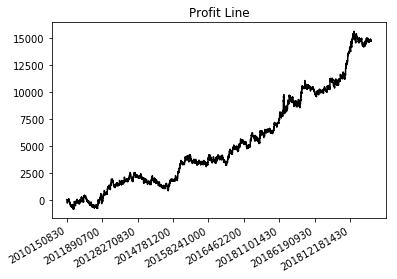

          數值
交易總筆數   4383
勝率      0.38
獲利因子    1.12
總淨利    14726


In [2]:
#k棒>=30 固定停損30 移動停利30    30分k
import backtest_function
from talib.abstract import*

# 載入繪圖套件
import matplotlib.pyplot as mp 
%matplotlib inline  

I020=backtest_function.GetI020()

StopLoss=30
back=30

TotalProfit=[0]
TotalProfit2=[0]

index=0

time=[]

for i in range(1,len(I020)):
    thisTime = I020[i][0]+I020[i][1]
    thisClose = int(I020[i][5])
    lastClose = int(I020[i-1][5])
    
    if index==0:
        if lastClose - thisClose >=30:
            index=-1
            OrderTime = thisTime
            OrderPrice = thisClose
            price=OrderPrice

        elif thisClose - lastClose >=30:
            index=1
            OrderTime = thisTime
            OrderPrice = thisClose
            price=OrderPrice

        elif i == len(I020)-1:
            # print(date,'No Trade')
            break
            
    elif index!=0:
        if index ==1:
            newstop=price-back
            if thisClose -price>=back:
                price=thisClose
                newstop=price-back
            if thisClose <= newstop:
                index=0
                CoverTime = thisTime            
                CoverPrice = thisClose
                Profit = CoverPrice - OrderPrice
                TotalProfit.append(TotalProfit[-1] + Profit)
                TotalProfit2.append(Profit)
                # print('B','OrderTime:',OrderTime,'OrderPrice:',OrderPrice,'CoverTime:',CoverTime,'CoverPrice:',CoverPrice,'Profit:',Profit)        
                time.append(CoverTime)
            else:
                if thisClose <= OrderPrice - StopLoss:
                    index=0
                    CoverTime = thisTime            
                    CoverPrice = thisClose
                    Profit = CoverPrice - OrderPrice
                    TotalProfit.append(TotalProfit[-1] + Profit)
                    TotalProfit2.append(Profit)
                    # print('B','OrderTime:',OrderTime,'OrderPrice:',OrderPrice,'CoverTime:',CoverTime,'CoverPrice:',CoverPrice,'Profit:',Profit)
                    time.append(CoverTime)
                    
        elif index ==-1:
            newstop=price+back
            if price -thisClose >=back:
                price=thisClose
                newstop=price+back
            if thisClose >= newstop:
                index=0
                CoverTime = thisTime
                CoverPrice = thisClose      
                Profit = OrderPrice - CoverPrice
                TotalProfit.append(TotalProfit[-1] + Profit)
                TotalProfit2.append(Profit)
                # print('S','OrderTime:',OrderTime,'OrderPrice:',OrderPrice,'CoverTime:',CoverTime,'CoverPrice:',CoverPrice,'Profit:',Profit)
                time.append(CoverTime)
                
            else:
                if thisClose >= OrderPrice + StopLoss:
                    index=0
                    CoverTime = thisTime
                    CoverPrice = thisClose      
                    Profit = OrderPrice - CoverPrice
                    TotalProfit.append(TotalProfit[-1] + Profit)
                    TotalProfit2.append(Profit)
                    # print('S','OrderTime:',OrderTime,'OrderPrice:',OrderPrice,'CoverTime:',CoverTime,'CoverPrice:',CoverPrice,'Profit:',Profit)
                    time.append(CoverTime)
                    
                    
#定義圖表物件        
ax = mp.subplot(111)

# 繪製圖案
ax.plot(range(len(TotalProfit)),TotalProfit, 'k-')

#x軸
ax.set_xticks(range(0,len(time),510))  # 510個為一組
ax.set_xticklabels(time[::510])        # 510個為一組

# 定義title
mp.title('Profit Line')

mp.gcf().autofmt_xdate() #字幕斜

# 顯示繪製圖表
mp.show()
# 儲存圖表
#plt.savefig('Total Profit.png')


import pandas as pd
#勝率 (獲利次數 / 交易總筆數)
v=0
for i in TotalProfit2:
    if i>0:
        v+=1                

#獲利因子 = 總收入/(-總虧損) >0  1.5  2
w=[]
l=[]
for i in TotalProfit2:
    if i>=0:
        w.append(i)
    elif i<0:
        l.append(i)

w1=sum(w)
l1=sum(l)                

dic={'交易總筆數':[len(TotalProfit2)],
'總淨利':[sum(TotalProfit2)],
'勝率':['{:.2f}'.format(v/len(TotalProfit2))],
'獲利因子':['{:.2f}'.format(w1/(-l1))]}        

# #橫向
df=pd.DataFrame(dic)  

#縱向
df1=df.T
df1.columns=['數值']
print(df1)

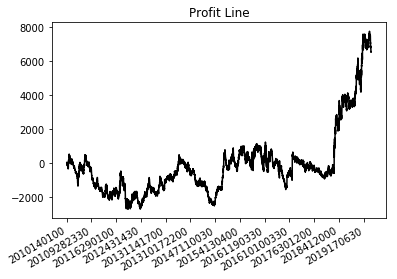

          數值
交易總筆數  14764
勝率      0.34
獲利因子    1.03
總淨利     6551


In [3]:
# KD+RSI 長短交叉
import backtest_function
from talib.abstract import*
import pandas as pd
import matplotlib.pyplot as mp 
%matplotlib inline 


I020=backtest_function.GetI020()

TotalProfit=[0]
TotalProfit2=[0]

index=0

day=[]

#轉換成pandas  因為ta-lib 配合使用
df=pd.DataFrame(I020)

#改屬性名稱
df.columns=['day','time','open','high','low','close','vol']

df['close']=df['close'].astype('float')
df['open']=df['open'].astype('float')
df['high']=df['high'].astype('float')
df['low']=df['low'].astype('float')

rsi_s=RSI(df['close'],6)
rsi_l=RSI(df['close'],12)

kd = STOCH(df,fastk_period=9, slowk_period=3, slowd_period=3)

dif,macd,osc = MACD(df.close, fastperiod=6, slowperiod=12, signalperiod=9)

for i in range(1,len(df)):
    thisTime=df['day'][i]+df['time'][i]
    thisClose=int(df['close'][i])
    lastClose=int(df['close'][i-1])
    
    k=kd.slowk[i]
    d=kd.slowd[i]
    
    rs=rsi_s[i]
    rl=rsi_l[i]
    
    dis=dif[i]
    mac=macd[i]
    
    if index==0:
        if k<d and rs<rl:
            index=-1
            OrderTime = thisTime
            OrderPrice = thisClose
            
        elif k>d and rs>rl: 
            index=1
            OrderTime = thisTime
            OrderPrice = thisClose
            
        elif i == len(df)-1:
            break
    
    elif index!=0:
        if index==1:
            if k<d and rs<rl:
                index=0
                CoverTime = thisTime
                CoverPrice = thisClose
                Profit = CoverPrice - OrderPrice
                TotalProfit.append(TotalProfit[-1] + Profit)
                TotalProfit2.append(Profit)
                day.append(CoverTime)
                
        elif index==-1:
            if k>d and rs>rl:
                index=0
                CoverTime = thisTime
                CoverPrice = thisClose
                Profit = OrderPrice - CoverPrice
                TotalProfit.append(TotalProfit[-1] + Profit)
                TotalProfit2.append(Profit)
                day.append(CoverTime)
                
# 定義圖表物件        
ax = mp.subplot(111)

# 繪製圖案
ax.plot(range(len(TotalProfit)),TotalProfit, 'k-')

#x軸
ax.set_xticks(range(0,len(day),1200))  # 1200個為一組
ax.set_xticklabels(day[::1200])        # 1200個為一組

# 定義title
mp.title('Profit Line')

mp.gcf().autofmt_xdate() #字幕斜

# 顯示繪製圖表
mp.show()
# 儲存圖表
#plt.savefig('Total Profit.png')


import pandas as pd
#勝率 (獲利次數 / 交易總筆數)
v=0
for i in TotalProfit2:
    if i>0:
        v+=1                

#獲利因子 = 總收入/(-總虧損) >0  1.5  2
w=[]
l=[]
for i in TotalProfit2:
    if i>=0:
        w.append(i)
    elif i<0:
        l.append(i)

w1=sum(w)
l1=sum(l)                


dic={'交易總筆數':[len(TotalProfit2)],
'總淨利':[sum(TotalProfit2)],
'勝率':['{:.2f}'.format(v/len(TotalProfit2))],
'獲利因子':['{:.2f}'.format(w1/(-l1))]}        

# #橫向
df=pd.DataFrame(dic)  

#縱向
df1=df.T
df1.columns=['數值']
print(df1)
